In [224]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

Installing bbSearch module from web ...
creating bbmodcache subfolder
downloading bbSearch module
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18767  100 18767    0     0   271k      0 --:--:-- --:--:-- --:--:--  273k


In [225]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

In [226]:
state = [[1,3,0,0,0,0,6],
         [1,3,4,4,0,0,0],
         [3,3,4,0,0,0,0],
         [0,4,4,2,0,0,0],
         [0,0,2,2,5,5,5]]

bs = BlockState(state)
# bs.display()

In [227]:
from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        #print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

In [228]:
import numpy as np

big_initial = [[0,0,1,1,0,0,2,2],
               [0,0,0,0,0,0,0,2],
               [3,3,3,0,0,0,0,2],
               [3,0,0,4,0,0,0,0],
               [0,0,0,4,0,5,5,5],
               [6,6,0,4,0,0,5,5],
               [0,6,0,0,0,0,0,0],
               [0,6,0,0,7,7,7,0]]

big_goal = [[0,0,0,0,0,0,0,4],
            [0,0,0,0,0,0,0,4],
            [0,0,0,0,0,0,0,4],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0]]

small_initial = [[0,0,1,1],
                 [4,4,1,0],
                 [0,2,6,0],
                 [2,2,6,0]]

small_goal    = [[0,0,0,0],
                 [0,0,0,0],
                 [0,0,1,1],
                 [0,0,1,0]]

complex_initial = [[0,1,2],
                   [3,4,5],
                   [6,7,8]]

complex_goal = [[8,7,6],
                [5,4,3],
                [2,1,0]]

random_initial = np.random.randint(0, 9, size=(100,100))

random_goal = random_initial

small_puzzle =  SlidingBlocksPuzzle( small_initial, small_goal )
complex_puzzle = SlidingBlocksPuzzle( complex_initial, complex_goal )
big_puzzle = SlidingBlocksPuzzle( big_initial, big_goal )

In [229]:
# Heuristics
def manhatten_heuristic(state):
    # Determine the goal position
    goal_i, goal_j = find_goal_position(small_goal, 1)

    # Find the position of the red block
    for i in range(len(state.blockstate)):
        for j in range(len(state.blockstate[i])):
            if state.blockstate[i][j] == 1:
                # Return the Manhattan distance from the red block to the goal position
                print(abs(i - goal_i) + abs(j - goal_j))
                return abs(i - goal_i) + abs(j - goal_j)

    # If the red block is not found, return a large distance
    return float('inf')

def find_goal_position(goal, value):
    for i in range(len(goal)):
        for j in range(len(goal[i])):
            if goal[i][j] == value:
                return i, j
    return -1, -1  # Value not found in goal

import math
def euclidean_heuristic(state):
    # Determine the goal position
    goal_i, goal_j = find_goal_position(small_goal, 1)

    # Find the position of the red block
    for i in range(len(state.blockstate)):
        for j in range(len(state.blockstate[i])):
            if state.blockstate[i][j] == 1:
                # Return the Euclidean distance from the red block to the goal position
                return math.sqrt((i - goal_i)**2 + (j - goal_j)**2)

    # If the red block is not found, return a large distance
    return float('inf')

def chebyshev_heuristic(state):
    # Determine the goal position
    goal_i, goal_j = find_goal_position(big_goal, 1)

    # Find the position of the red block
    for i in range(len(state.blockstate)):
        for j in range(len(state.blockstate[i])):
            if state.blockstate[i][j] == 1:
                # Return the Chebyshev distance from the red block to the goal position
                return max(abs(i - goal_i), abs(j - goal_j))

    # If the red block is not found, return a large distance
    return float('inf')

Solve the following sliding blocks problem.
Get from this initial state:


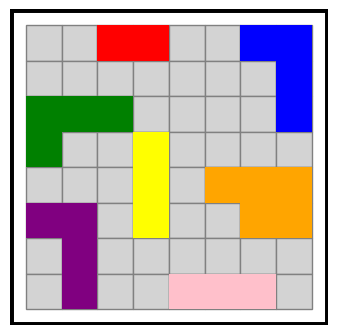

To a state incorporating the following block position(s):


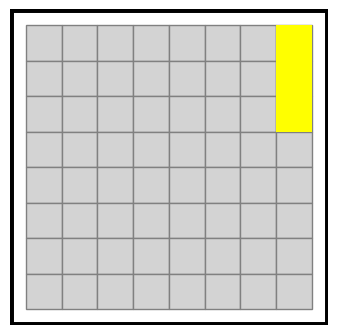


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 1084
Goal state is:


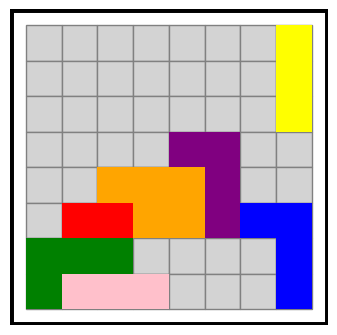

The action path to the solution is:
('green', 'down')
('orange', 'up')
('pink', 'up')
('green', 'up')
('red', 'right')
('yellow', 'up')
('pink', 'down')
('orange', 'down')
('blue', 'down')
('green', 'down')
('yellow', 'down')
('pink', 'right')
('yellow', 'down')
('red', 'left')
('red', 'left')
('green', 'up')
('pink', 'left')
('orange', 'left')
('yellow', 'up')
('pink', 'right')
('pink', 'up')
('blue', 'left')
('red', 'right')
('green', 'right')
('purple', 'right')
('purple', 'up')
('red', 'left')
('red', 'left')
('green', 'right')
('orange', 'right')
('red', 'down')
('purple', 'left')
('green', 'up')
('purple', 'down')
('yellow', 'down')
('green', 'down')
('pink', 'down')
('orange', 'left')
('orange', 'down')
('red', 'up')
('blue', 'down')
('purple', 'right')
('red', 'right')
('green', 'left')
('green', 'down')
('yellow', 'down')
('blue', 'left')
('blue', 'up')
('green', 'left')
('red', 'down')
('blue', 'up')
('pink', 'left')
('purple', 'left')
('orange', 'right')
('red', 'left')
('bl

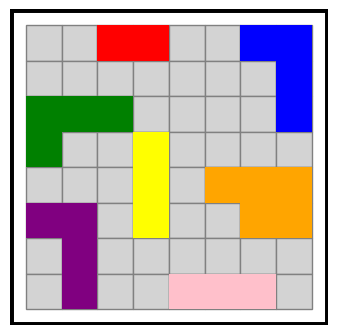

To a state incorporating the following block position(s):


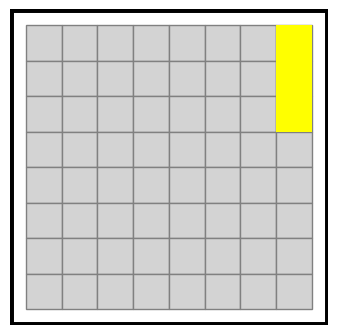


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 124
Goal state is:


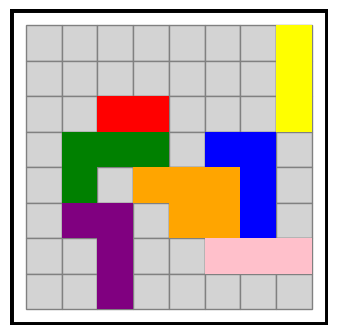

The action path to the solution is:
('red', 'down')
('yellow', 'down')
('blue', 'down')
('green', 'down')
('red', 'down')
('purple', 'right')
('pink', 'right')
('orange', 'left')
('green', 'down')
('blue', 'left')
('blue', 'up')
('pink', 'up')
('orange', 'right')
('blue', 'left')
('yellow', 'down')
('yellow', 'right')
('orange', 'up')
('pink', 'up')
('blue', 'right')
('yellow', 'left')
('green', 'up')
('yellow', 'up')
('yellow', 'right')
('purple', 'up')
('purple', 'right')
('green', 'right')
('yellow', 'up')
('yellow', 'up')
('blue', 'right')
('green', 'left')
('pink', 'down')
('pink', 'down')
('green', 'right')
('blue', 'left')
('yellow', 'up')
('pink', 'up')
('purple', 'right')
('yellow', 'up')
('green', 'left')
('purple', 'left')
('pink', 'up')
('orange', 'left')
('purple', 'right')
('green', 'right')
('blue', 'right')
('yellow', 'right')
('orange', 'right')
('green', 'left')
('purple', 'up')
('green', 'down')
('green', 'down')
('purple', 'left')
('yellow', 'left')
('pink', 'down')

In [230]:
heuristicNoneTime = 0
heuristicTime = 0
heuristicNonePathLength = 0
heuristicPathLength = 0

for _ in range(1):
    small_search = search( big_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False, 
                        return_info=True, show_path=False, heuristic=None)
    heuristicNoneTime += small_search["search_stats"]["time_taken"]

    if type(small_search["result"]["path_length"]) is int:
        heuristicNonePathLength += small_search["result"]["path_length"]

    small_search_heuristic = search( big_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False,
                        return_info=True, show_path=False, heuristic=euclidean_heuristic)
    heuristicTime += small_search_heuristic["search_stats"]["time_taken"]
    
    if type(small_search_heuristic["result"]["path_length"]) is int:
        heuristicPathLength += small_search_heuristic["result"]["path_length"]
    

In [231]:
print("No Heuristic: ", heuristicNoneTime/1)
print("Heuristic: ", heuristicTime/1)
print("Path length: ", heuristicNonePathLength/1)
print("Path length: ", heuristicPathLength/1)

No Heuristic:  3.3248262840006646
Heuristic:  0.4289331059990218
Path length:  1084.0
Path length:  124.0
